/var/folders/8_/lltwgz4x48ncx3q3k86fr_tm0000gq/T/ipykernel_81942/1993143234.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODEL_PATH, map_loca

28


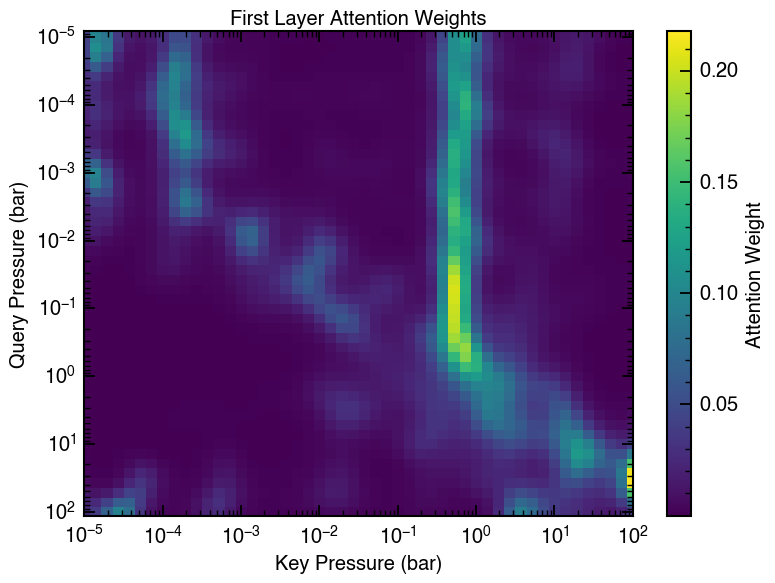

In [1]:
#!/usr/bin/env python3
"""
attention_plot_pressure.py - Script to visualize attention with pressure on both axes in log scale
"""
import sys
sys.path.append('../src')

import json
import json5
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt
from utils import create_prediction_model
from normalizer import DataNormalizer

plt.style.use('science.mplstyle')

# Hard-coded paths
DATA_PATH = "../data/normalized_profiles"
METADATA_PATH = "../data/normalized_profiles/normalization_metadata.json"
MODEL_PATH = "../data/model/best_model.pt"
CONFIG_PATH = "../inputs/model_input_params.jsonc"

# Load configuration and model
with open(CONFIG_PATH, 'r') as f:
    config = json5.load(f)

input_vars = config["input_variables"]
target_vars = config["target_variables"]
coord_var = "pressure"

checkpoint = torch.load(MODEL_PATH, map_location='cpu')
model = create_prediction_model(config)
model.load_state_dict(checkpoint['state_dict'], strict=False)
model.eval()

# Load normalization metadata
with open(METADATA_PATH, 'r') as f:
    metadata = json.load(f)

# Load a profile for testing
file_num = np.random.randint(0, 100)
print(file_num)
test_files = [f for f in Path(DATA_PATH).glob("*.json") if f.name != "normalization_metadata.json"]
test_file = test_files[file_num if file_num < len(test_files) else 0]
with open(test_file, 'r') as f:
    profile = json.load(f)

# Prepare inputs
coord_vals = profile.get(coord_var, [])
if not isinstance(coord_vals, list): coord_vals = [coord_vals]
seq_len = len(coord_vals)

inputs = {}
seq_type = list(config.get("sequence_types", {"profile": []}).keys())[0]
seq_indices = config.get("sequence_types", {"profile": []})[seq_type]

if seq_indices:
    seq_features = []
    for idx in seq_indices:
        val = profile.get(input_vars[idx], 0)
        if isinstance(val, list):
            values = val[:seq_len] if len(val) >= seq_len else val + [val[-1]] * (seq_len - len(val))
        else:
            values = [float(val)] * seq_len
        seq_features.append(torch.tensor(values, dtype=torch.float32))
    inputs[seq_type] = torch.stack(seq_features, dim=1).unsqueeze(0)

global_indices = config.get("global_feature_indices", [])
if global_indices:
    global_values = []
    for idx in global_indices:
        val = profile.get(input_vars[idx], 0)
        val_float = float(val[0]) if isinstance(val, list) and val else float(val)
        global_values.append(val_float)
    inputs["global"] = torch.tensor(global_values, dtype=torch.float32).unsqueeze(0)

# Create a custom attention module to visualize
class VisualizableAttention(torch.nn.Module):
    def __init__(self, original_module):
        super().__init__()
        self.d_model = original_module.d_model
        self.nhead = original_module.nhead
        self.head_dim = original_module.head_dim
        self.q_proj = original_module.q_proj
        self.k_proj = original_module.k_proj
        self.v_proj = original_module.v_proj
        self.out_proj = original_module.out_proj
        self.dropout = original_module.dropout
        self.attention_weights = None
    
    def forward(self, x, attn_mask=None):
        batch_size, seq_len, _ = x.shape
        q = self.q_proj(x).view(batch_size, seq_len, self.nhead, self.head_dim).transpose(1, 2)
        k = self.k_proj(x).view(batch_size, seq_len, self.nhead, self.head_dim).transpose(1, 2)
        v = self.v_proj(x).view(batch_size, seq_len, self.nhead, self.head_dim).transpose(1, 2)
        scores = torch.matmul(q, k.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float))
        if attn_mask is not None:
            scores = scores + attn_mask
        attn_weights = torch.nn.functional.softmax(scores, dim=-1)
        self.attention_weights = attn_weights.detach()
        attn_weights = self.dropout(attn_weights)
        attn_output = torch.matmul(attn_weights, v)
        attn_output = attn_output.transpose(1, 2).reshape(batch_size, seq_len, self.d_model)
        return self.out_proj(attn_output)

# Replace only the first layer attention module
first_attn_module = None
for name, module in model.named_modules():
    if "self_attn" in name and hasattr(module, "q_proj") and hasattr(module, "k_proj"):
        parent_name = '.'.join(name.split('.')[:-1])
        parent_module = model
        for part in parent_name.split('.'):
            if part:
                parent_module = getattr(parent_module, part)
        
        module_name = name.split('.')[-1]
        visualizable_module = VisualizableAttention(module)
        setattr(parent_module, module_name, visualizable_module)
        first_attn_module = visualizable_module
        break  # Only replace the first attention module

# Run forward pass to capture attention weights
with torch.no_grad():
    model(inputs)

# Plot attention map
if first_attn_module and first_attn_module.attention_weights is not None:
    attn_map = first_attn_module.attention_weights.mean(dim=1)[0].cpu().numpy()
    
    # Denormalize pressure values
    coord_denorm = np.array(DataNormalizer.denormalize(coord_vals, metadata, coord_var)).flatten()
    
    # Create a new figure with a specific size
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Create a mesh grid for pcolormesh
    Y, X = np.meshgrid(coord_denorm, coord_denorm)
    
    # Plot the attention matrix using pcolormesh
    im = ax.pcolormesh(X, Y, attn_map.T, cmap='viridis', shading='auto')
    
    # Set log scale for both axes
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    # Add labels
    ax.set_xlabel("Key Pressure (bar)")
    ax.set_ylabel("Query Pressure (bar)")
    ax.set_title("First Layer Attention Weights")
    
    # Invert both axes so lower pressure is at the top/left
    ax.invert_xaxis()
    ax.invert_yaxis()
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Attention Weight')
    
    # Improve layout
    plt.tight_layout()
    plt.xlim(1e-5, 1e2)
    
    # Save the figure
    output_dir = Path("../plots")
    output_dir.mkdir(exist_ok=True)
    plt.savefig(output_dir / "first_layer_attention_pressure.png")
    plt.show()
else:
    print("Could not capture attention weights")

/var/folders/8_/lltwgz4x48ncx3q3k86fr_tm0000gq/T/ipykernel_81942/3347196325.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODEL_PATH, map_loca

Using profile: 81
Found 8 attention modules
Replaced first layer attention module: sequence_encoders.profile.layers.0.self_attn

Top 5 most attended pressure levels in first layer:
  1. 5.18e-01 bar: 0.1092
  2. 7.20e-01 bar: 0.0930
  3. 3.73e-01 bar: 0.0664
  4. 1.00e+00 bar: 0.0534
  5. 1.39e+00 bar: 0.0325


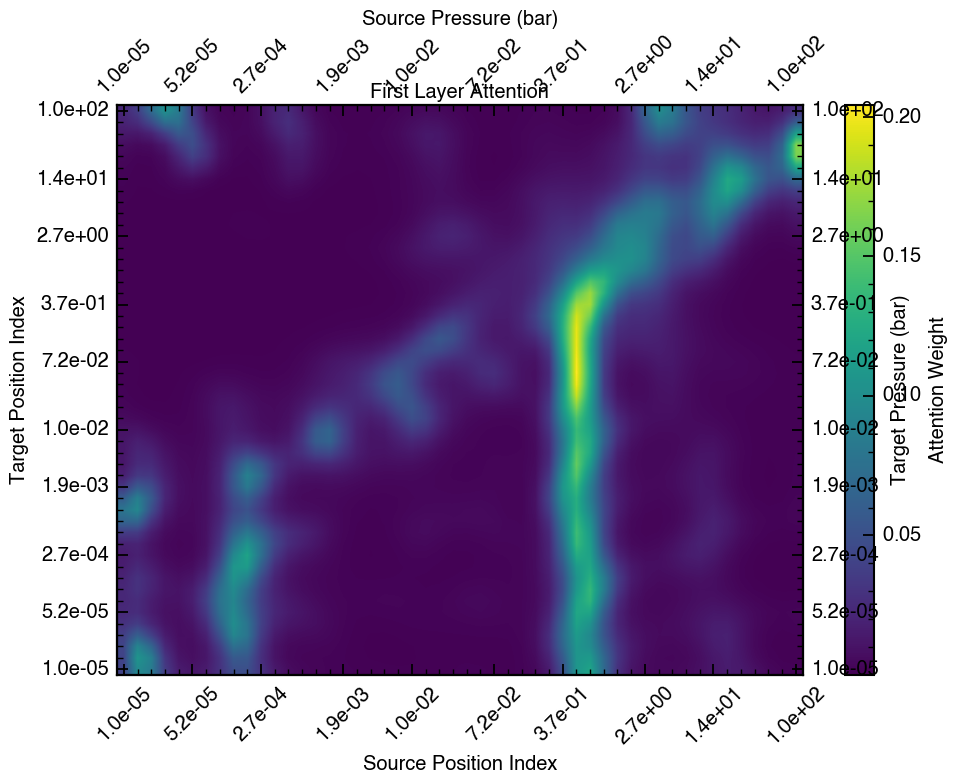

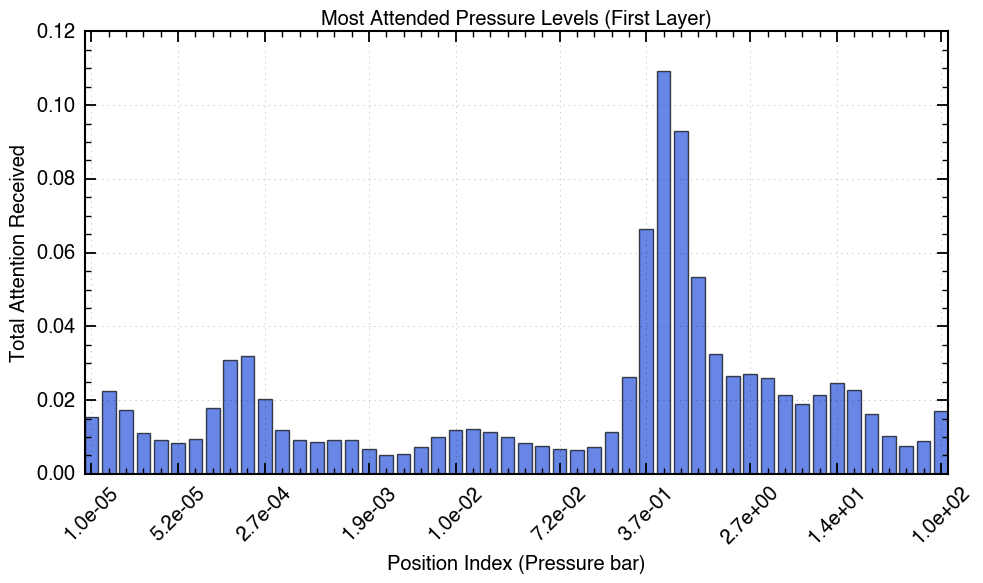

In [4]:
#!/usr/bin/env python3
"""
first_layer_attention_plot.py - Visualization of first layer attention patterns
"""
import sys
sys.path.append('../src')

import json
import json5
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt
from utils import create_prediction_model
from normalizer import DataNormalizer

plt.style.use('science.mplstyle')

# Hard-coded paths
DATA_PATH = "../data/normalized_profiles"
METADATA_PATH = "../data/normalized_profiles/normalization_metadata.json"
MODEL_PATH = "../data/model/best_model.pt"
CONFIG_PATH = "../inputs/model_input_params.jsonc"

# Load configuration and model
with open(CONFIG_PATH, 'r') as f:
    config = json5.load(f)

input_vars = config["input_variables"]
target_vars = config["target_variables"]
coord_var = "pressure"

checkpoint = torch.load(MODEL_PATH, map_location='cpu')
model = create_prediction_model(config)
model.load_state_dict(checkpoint['state_dict'], strict=False)
model.eval()

# Load normalization metadata
with open(METADATA_PATH, 'r') as f:
    metadata = json.load(f)

# Load a profile for testing
file_num = np.random.randint(0, 100)
print(f"Using profile: {file_num}")
test_files = [f for f in Path(DATA_PATH).glob("*.json") if f.name != "normalization_metadata.json"]
test_file = test_files[file_num if file_num < len(test_files) else 0]
with open(test_file, 'r') as f:
    profile = json.load(f)

# Prepare inputs
coord_vals = profile.get(coord_var, [])
if not isinstance(coord_vals, list): coord_vals = [coord_vals]
seq_len = len(coord_vals)

inputs = {}
seq_type = list(config.get("sequence_types", {"profile": []}).keys())[0]
seq_indices = config.get("sequence_types", {"profile": []})[seq_type]

if seq_indices:
    seq_features = []
    for idx in seq_indices:
        val = profile.get(input_vars[idx], 0)
        if isinstance(val, list):
            values = val[:seq_len] if len(val) >= seq_len else val + [val[-1]] * (seq_len - len(val))
        else:
            values = [float(val)] * seq_len
        seq_features.append(torch.tensor(values, dtype=torch.float32))
    inputs[seq_type] = torch.stack(seq_features, dim=1).unsqueeze(0)

global_indices = config.get("global_feature_indices", [])
if global_indices:
    global_values = []
    for idx in global_indices:
        val = profile.get(input_vars[idx], 0)
        val_float = float(val[0]) if isinstance(val, list) and val else float(val)
        global_values.append(val_float)
    inputs["global"] = torch.tensor(global_values, dtype=torch.float32).unsqueeze(0)

# Create a custom attention module to visualize
class VisualizableAttention(torch.nn.Module):
    def __init__(self, original_module):
        super().__init__()
        self.d_model = original_module.d_model
        self.nhead = original_module.nhead
        self.head_dim = original_module.head_dim
        self.q_proj = original_module.q_proj
        self.k_proj = original_module.k_proj
        self.v_proj = original_module.v_proj
        self.out_proj = original_module.out_proj
        self.dropout = original_module.dropout
        self.attention_weights = None
    
    def forward(self, x, attn_mask=None):
        batch_size, seq_len, _ = x.shape
        q = self.q_proj(x).view(batch_size, seq_len, self.nhead, self.head_dim).transpose(1, 2)
        k = self.k_proj(x).view(batch_size, seq_len, self.nhead, self.head_dim).transpose(1, 2)
        v = self.v_proj(x).view(batch_size, seq_len, self.nhead, self.head_dim).transpose(1, 2)
        scores = torch.matmul(q, k.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float))
        if attn_mask is not None:
            scores = scores + attn_mask
        attn_weights = torch.nn.functional.softmax(scores, dim=-1)
        self.attention_weights = attn_weights.detach()
        attn_weights = self.dropout(attn_weights)
        attn_output = torch.matmul(attn_weights, v)
        attn_output = attn_output.transpose(1, 2).reshape(batch_size, seq_len, self.d_model)
        return self.out_proj(attn_output)

# Get all attention modules
attn_modules = []
for name, module in model.named_modules():
    if "self_attn" in name and hasattr(module, "q_proj") and hasattr(module, "k_proj"):
        attn_modules.append((name, module))
        
# Sort modules by name to identify layers
attn_modules.sort(key=lambda x: x[0])
print(f"Found {len(attn_modules)} attention modules")

# Replace the first layer attention module
first_name, first_module = attn_modules[0]
parent_name = '.'.join(first_name.split('.')[:-1])
parent_module = model
for part in parent_name.split('.'):
    if part:
        parent_module = getattr(parent_module, part)

module_name = first_name.split('.')[-1]
visualizable_module = VisualizableAttention(first_module)
setattr(parent_module, module_name, visualizable_module)
attention_module = visualizable_module

print(f"Replaced first layer attention module: {first_name}")

# Run forward pass to capture attention weights
with torch.no_grad():
    model(inputs)

# Plot 2D attention visualization
if attention_module.attention_weights is not None:
    # Get attention weights (average across heads)
    attn_map = attention_module.attention_weights.mean(dim=1)[0].cpu().numpy()
    
    # Get the actual pressure values
    pressure_values = np.array(DataNormalizer.denormalize(coord_vals, metadata, coord_var)).flatten()
    
    # Check for non-positive values and fix them if needed
    if np.any(pressure_values <= 0):
        print("Warning: Found non-positive pressure values, setting minimum to 1e-10")
        pressure_values = np.maximum(pressure_values, 1e-10)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Use imshow instead of pcolormesh to avoid log scale issues
    im = ax.imshow(attn_map, aspect='auto', origin='lower', cmap='viridis')
    
    # Add labels
    ax.set_xlabel("Source Position Index")
    ax.set_ylabel("Target Position Index")
    ax.set_title("First Layer Attention")
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Attention Weight')
    
    # Set ticks with pressure values
    num_ticks = min(10, len(pressure_values))
    tick_indices = np.linspace(0, len(pressure_values)-1, num_ticks, dtype=int)
    
    # X-axis pressure labels
    ax.set_xticks(tick_indices)
    ax.set_xticklabels([f"{pressure_values[idx]:.1e}" for idx in tick_indices], rotation=45)
    
    # Y-axis pressure labels
    ax.set_yticks(tick_indices)
    ax.set_yticklabels([f"{pressure_values[idx]:.1e}" for idx in tick_indices])
    
    # Add secondary axes for pressure values
    ax_top = ax.twiny()
    ax_top.set_xlim(ax.get_xlim())
    ax_top.set_xticks(tick_indices)
    ax_top.set_xticklabels([f"{pressure_values[idx]:.1e}" for idx in tick_indices], rotation=45)
    ax_top.set_xlabel("Source Pressure (bar)")
    
    ax_right = ax.twinx()
    ax_right.set_ylim(ax.get_ylim())
    ax_right.set_yticks(tick_indices)
    ax_right.set_yticklabels([f"{pressure_values[idx]:.1e}" for idx in tick_indices])
    ax_right.set_ylabel("Target Pressure (bar)")
    
    # Improve layout
    plt.tight_layout()
    
    # Save the figure
    output_dir = Path("../plots")
    output_dir.mkdir(exist_ok=True)
    plt.savefig(output_dir / "first_layer_attention_2d.png")
    
    # Create a 1D summary plot showing which pressures receive most attention
    plt.figure(figsize=(10, 6))
    
    # Calculate total attention received by each pressure level
    attention_by_pressure = attn_map.sum(axis=0)
    attention_by_pressure = attention_by_pressure / attention_by_pressure.sum()
    
    # Plot 1D attention summary
    plt.bar(range(len(attention_by_pressure)), attention_by_pressure, width=0.8, alpha=0.7)
    
    # Set x-axis ticks to pressure values
    plt.xticks(tick_indices, [f"{pressure_values[idx]:.1e}" for idx in tick_indices], rotation=45)
    
    plt.xlabel("Position Index (Pressure bar)")
    plt.ylabel("Total Attention Received")
    plt.title("Most Attended Pressure Levels (First Layer)")
    plt.grid(True, alpha=0.3)
    
    # Print most important pressure levels
    top_indices = np.argsort(-attention_by_pressure)[:5]
    print("\nTop 5 most attended pressure levels in first layer:")
    for i, idx in enumerate(top_indices):
        print(f"  {i+1}. {pressure_values[idx]:.2e} bar: {attention_by_pressure[idx]:.4f}")
    
    plt.tight_layout()
    plt.savefig(output_dir / "first_layer_pressure_attention.png")
    
    plt.show()
else:
    print("Could not capture attention weights")